# **Aprendizaje supervisado**
# SL14. Ejercicio de gradient boosting

## <font color='blue'>**Carseats Dataset**</font> 

El set de datos **Carseats**, original del paquete de R ISLR y accesible en Python a través de ``statsmodels.datasets.get_rdataset``, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.


In [2]:
# Importar las librerías

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Cargar el dataset
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

In [5]:
datos.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


Hay que convertir a variables númericas "ShelveLoc", "Urban" y "US". Se revisará si hay valores nulos

In [8]:
datos.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

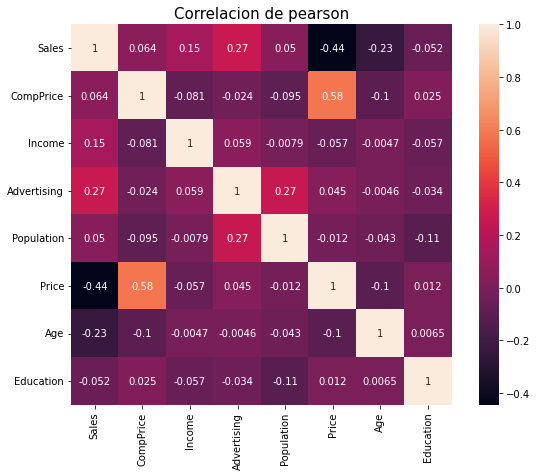

In [12]:
#se evalua la correlacion entre variables
import seaborn as sns

plt.figure(figsize=(10,7))
plt.title('Correlacion de pearson', size = 15)
sns.heatmap(datos.corr(),
            square = True,
            annot = True)
plt.show()

In [13]:
cat_cols = ['Education', 'ShelveLoc', 'Urban', 'US']
for col in datos:
  if datos[col].dtype == 'object':
    print(f"Feature Name {col} : \n{datos[col].value_counts()}")

Feature Name ShelveLoc : 
Medium    219
Bad        96
Good       85
Name: ShelveLoc, dtype: int64
Feature Name Urban : 
Yes    282
No     118
Name: Urban, dtype: int64
Feature Name US : 
Yes    258
No     142
Name: US, dtype: int64


Entonces, ShelveLoc tiene 3 categorias (Medium, Bad y Good) y, Urban y US son variables binarias (Yes/No)

In [15]:
#se utilizará get_dummies

X = pd.get_dummies(datos)
X.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,9.50,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,11.22,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,10.06,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,7.40,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,4.15,141,64,3,340,128,38,13,1,0,0,0,1,1,0


Se define la variable dependiente (y) y los datos para el ajuste (X)

In [ ]:
y = X['Sales']
X = X.drop('Sales', axis=1)


In [20]:
# Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene 
# ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

y_binario = (y >8)*1 + (y<=8)*0


In [22]:
y[0:5]

0     9.50
1    11.22
2    10.06
3     7.40
4     4.15
Name: Sales, dtype: float64

In [23]:
y_binario[0:5]

0    1
1    1
2    1
3    0
4    0
Name: Sales, dtype: int64

Se entrena el modelo de Gradient Boosting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binario, test_size=0.3, random_state=101)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

model_GB = GradientBoostingClassifier(max_depth=5, n_estimators=100, random_state=101)
model_GB.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=101)

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, accuracy_score

y_pred = model_GB.predict(X_test)

report = classification_report(y_test, y_pred, target_names= ['VentasBaja', 'VentasAlta'])

print(report)

              precision    recall  f1-score   support

  VentasBaja       0.88      0.84      0.86        76
  VentasAlta       0.74      0.80      0.77        44

    accuracy                           0.82       120
   macro avg       0.81      0.82      0.81       120
weighted avg       0.83      0.82      0.83       120



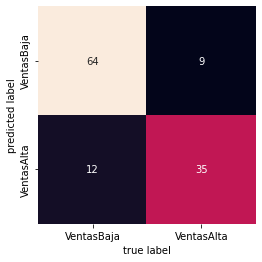

In [33]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['VentasBaja', 'VentasAlta'], yticklabels=['VentasBaja', 'VentasAlta'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [35]:
print(f'f1 : {f1_score(y_test, y_pred):.3f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')

f1 : 0.769
Accuracy: 0.825
Recall: 0.795
